In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [3]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

In [4]:
len(train_ds.anchor_data), len(train_ds.anchor_labels), len(eval_ds.anchor_data), len(eval_ds.anchor_labels)

(300, 300, 100, 100)

In [5]:
BATCH_SIZE = 16

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity


loss_history = []
accuracy_history = []

def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0
        
        for inputs, labels in train_loader:
            
            input_anchor, input_pos, input_neg = inputs
            # label_anchor, label_pos, label_neg = labels
            
            input_anchor = input_anchor.to(device)
            input_pos = input_pos.to(device)
            input_neg = input_neg.to(device)
            
            emb_anchor = model(input_anchor)
            emb_pos = model(input_pos)
            emb_neg = model(input_neg)
            
            loss = criterion(emb_anchor, emb_pos, emb_neg)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            
        loss_history.append(loss.item())    
        
        scheduler.step(val_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        embeddings = []
        targets = []
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                input_anchor, input_pos, input_neg = inputs
                label_anchor, label_pos, label_neg = labels
                
                batch_emb, batch_lab = [], []
                
                input_anchor = input_anchor.to(device)
                input_pos = input_pos.to(device)
                input_neg = input_neg.to(device)
                
                emb_anchor = model(input_anchor)
                emb_pos = model(input_pos)
                emb_neg = model(input_neg)
                
                # embeddings.extend(emb_anchor)
                batch_emb.extend(emb_pos.cpu())
                batch_emb.extend(emb_neg.cpu())
                
                # labels.extend(label_anchor)
                batch_lab.extend(label_pos.cpu().tolist())
                batch_lab.extend(label_neg.cpu().tolist())
                
                embeddings.extend(batch_emb)
                targets.extend(batch_lab)
                
                
                loss = criterion(emb_anchor, emb_pos, emb_neg)
                val_loss += loss.item()
        
        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        
        embeddings = np.array(embeddings)
        targets = np.array(targets)
        
        # Get cosine similarity for all embeddings
        similarity_matrix = cosine_similarity(embeddings)
        
        # Fill diagonal with inf
        np.fill_diagonal(similarity_matrix, -np.inf)
        
        # Find the index of max sim for each embedding
        most_similar_indices = np.argmax(similarity_matrix, axis=1)
        
        # Extract the labels of the most similar items
        predicted_labels = [targets[i] for i in most_similar_indices]
        
        
        # Get number of correct predictions
        # n_correct = sum(1 for true_label, predicted_label in zip(labels, predicted_labels) if true_label == predicted_label)
        n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)
        
        print("Number of correct matches: ", n_correct)

        val_acc = 100 * (n_correct / len(embeddings))

        accuracy_history.append(val_acc)
        
        print(f"Validation accuracy: {val_acc:0.3f}%")
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved with validation loss:", best_val_loss)


In [7]:
inputs, labels = next(iter(eval_dl))

a, p, n = inputs
a.shape, p.shape, n.shape

a, p, n = labels
a.shape, p.shape, n.shape, a, p, n


(torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 tensor([100, 142,  90,  47,  97, 114, 129, 130, 119, 144, 125,  45,  52,  24,
          89, 143]),
 tensor([100, 142,  90,  47,  97, 114, 129, 130, 119, 144, 125,  45,  52,  24,
          89, 143]),
 tensor([ 93, 116, 142,  69, 104, 131,  83, 115, 100, 105,  58,  71, 111, 121,
         131, 128]))

### 2. Get model & train

In [8]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()
model = model.to(device)

/home/sebastijan/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sebastijan/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
LR = 1e-3

n_epochs = 100

criterion = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [10]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, "models/resnet50")

Number of correct matches:  79
Validation accuracy: 39.500%
Epoch 1/100, Train Loss: 1.9359, Valid Loss: 2.5270
Model saved with validation loss: 2.5269641876220703
Number of correct matches:  79
Validation accuracy: 39.500%
Epoch 2/100, Train Loss: 1.1272, Valid Loss: 1.0567
Model saved with validation loss: 1.0567207336425781
Number of correct matches:  82
Validation accuracy: 41.000%
Epoch 3/100, Train Loss: 0.7192, Valid Loss: 1.1258
Number of correct matches:  82
Validation accuracy: 41.000%
Epoch 4/100, Train Loss: 0.6887, Valid Loss: 0.9330
Model saved with validation loss: 0.9329923476491656
Number of correct matches:  80
Validation accuracy: 40.000%
Epoch 5/100, Train Loss: 0.6860, Valid Loss: 0.9143
Model saved with validation loss: 0.9143205199922834
Number of correct matches:  80
Validation accuracy: 40.000%
Epoch 6/100, Train Loss: 0.5546, Valid Loss: 0.7321
Model saved with validation loss: 0.7321223531450544
Number of correct matches:  81
Validation accuracy: 40.500%
Epo

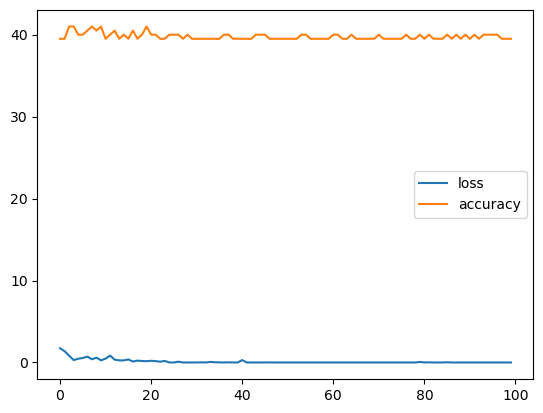

In [14]:
import matplotlib.pyplot as plt


plt.plot(loss_history, label="loss")
plt.plot(accuracy_history, label="accuracy")
plt.legend()

In [11]:
a = torch.tensor([1,2,3,4,4])
a
b = []
b.extend(a.tolist())
b

[1, 2, 3, 4, 4]